# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.sample(4)

,file_name,real_age
866,000866.jpg,7
3008,003008.jpg,29
2900,002900.jpg,30
5013,005013.jpg,2


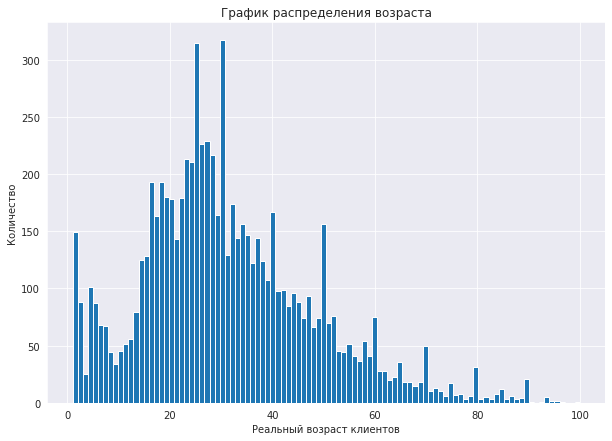

In [5]:
sns.set_style('darkgrid')

data['real_age'].hist(bins=100,figsize=(10, 7))

plt.title('График распределения возраста')
plt.xlabel('Реальный возраст клиентов')
plt.ylabel('Количество')

plt.show()

In [6]:
kids = data['real_age'] <= 19
adults = (data['real_age'] >= 20) & (data['real_age'] < 60)
elderly = data['real_age'] >= 60

In [7]:
print(f'Доля детей: {kids.mean():.2%}')
print(f'Доля взрослых: {adults.mean():.2%}')
print(f'Доля пожилых: {elderly.mean():.2%}')

Доля детей: 24.71%
Доля взрослых: 68.42%
Доля пожилых: 6.86%


In [8]:
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)

In [9]:
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
features, target = next(train_datagen_flow)

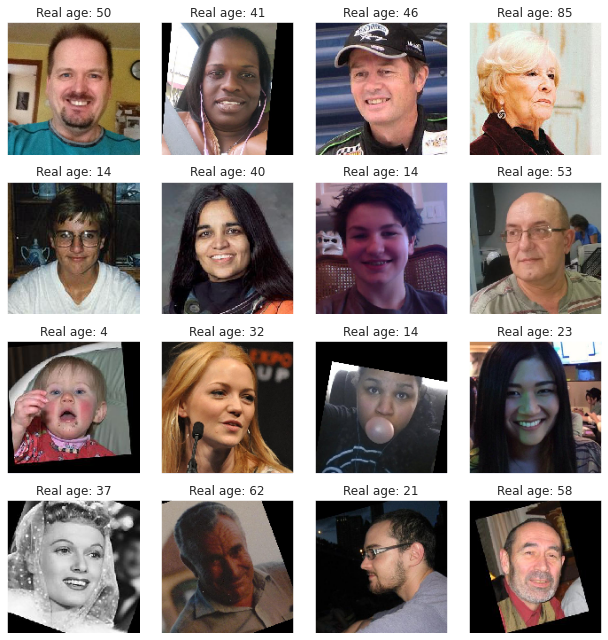

In [33]:
fig = plt.figure(figsize=(9, 9))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Real age: {}'.format(target[i]))

**Вывод:**

Перед нами задача регрессии

В распоряжении 7591 файлов с изображениями, где хранятся два признака: фото и реальный возраст людей.
Минимум начинается с 1 года, средний возраст - 31, максимум - 100. 

Основной контингент занимающий 68% - взрослые, доля детей занимает 24%, пожилые 6.8%

Что же касается самих фото, то они различаются по размеру, есть повернутые фотографии под разным углом, черно-белые, так же на некоторых фотографиях есть обеъекты прекрывающие лица: микрофон, жвачка...

## Обучение модели

```python

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import GlobalMaxPool2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    
    dataframe = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
    
    dataframe = pd.read_csv(path + '/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return val_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPool2D())
    model.add(Dense(67, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0002)
 
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae']) 
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=22,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs)
    return model
```

```
Train for 356 steps, validate for 119 steps

Epoch 1/22
356/356 - 65s - loss: 12.5485 - mae: 12.5496 - val_loss: 23.3754 - val_mae: 23.3744
Epoch 2/22
356/356 - 39s - loss: 8.5494 - mae: 8.5488 - val_loss: 17.1345 - val_mae: 17.1237
Epoch 3/22
356/356 - 38s - loss: 6.9201 - mae: 6.9207 - val_loss: 9.9267 - val_mae: 9.9256
Epoch 4/22
356/356 - 38s - loss: 5.9699 - mae: 5.9702 - val_loss: 14.6843 - val_mae: 14.6722
Epoch 5/22
356/356 - 49s - loss: 5.5948 - mae: 5.5953 - val_loss: 7.9201 - val_mae: 7.9223
Epoch 6/22
356/356 - 60s - loss: 4.9605 - mae: 4.9602 - val_loss: 7.0030 - val_mae: 7.0059
Epoch 7/22
356/356 - 61s - loss: 4.4261 - mae: 4.4258 - val_loss: 7.7149 - val_mae: 7.7192
Epoch 8/22
356/356 - 60s - loss: 4.2152 - mae: 4.2154 - val_loss: 6.8324 - val_mae: 6.8349
Epoch 9/22
356/356 - 61s - loss: 4.0087 - mae: 4.0087 - val_loss: 7.3376 - val_mae: 7.3352
Epoch 10/22
356/356 - 59s - loss: 3.7645 - mae: 3.7649 - val_loss: 7.6664 - val_mae: 7.6695
Epoch 11/22
356/356 - 59s - loss: 3.6554 - mae: 3.6555 - val_loss: 7.1640 - val_mae: 7.1687
Epoch 12/22
356/356 - 38s - loss: 3.4462 - mae: 3.4460 - val_loss: 7.2876 - val_mae: 7.2868
Epoch 13/22
356/356 - 38s - loss: 3.3492 - mae: 3.3492 - val_loss: 6.8393 - val_mae: 6.8428
Epoch 14/22
356/356 - 37s - loss: 3.1850 - mae: 3.1849 - val_loss: 6.8416 - val_mae: 6.8439
Epoch 15/22
356/356 - 38s - loss: 3.0512 - mae: 3.0513 - val_loss: 6.6643 - val_mae: 6.6681
Epoch 16/22
356/356 - 38s - loss: 3.0364 - mae: 3.0364 - val_loss: 6.6034 - val_mae: 6.6030
Epoch 17/22
356/356 - 38s - loss: 2.9499 - mae: 2.9502 - val_loss: 6.5013 - val_mae: 6.5103
Epoch 18/22
356/356 - 38s - loss: 2.8805 - mae: 2.8805 - val_loss: 6.6572 - val_mae: 6.6620
Epoch 19/22
356/356 - 38s - loss: 2.7282 - mae: 2.7280 - val_loss: 6.4760 - val_mae: 6.4804
Epoch 20/22
356/356 - 38s - loss: 2.6537 - mae: 2.6538 - val_loss: 6.4934 - val_mae: 6.4952
Epoch 21/22
356/356 - 38s - loss: 2.6965 - mae: 2.6964 - val_loss: 6.5987 - val_mae: 6.6000
Epoch 22/22
356/356 - 38s - loss: 2.5940 - mae: 2.5941 - val_loss: 6.3373 - val_mae: 6.3476


119/119 - 9s - loss: 6.3373 - mae: 6.3476
Test MAE: 6.3476




```

## Анализ обученной модели

  В рамках проекта решаем задачу для сетевого супермаркета «Хлеб-Соль», которая внедряет систему компьютерного зрения для обработки фотографий покупателей.

**Цель проекта:** Построить модель, что по фотографии определит приблизительный возраст человека.

**Задачи проекта:** 
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.

Всего 7591 файлов с изображениями. В процессе исследовательского анализа выяснилось, что данные возрастных категорий распределяются неравномерно:
- Доля детей: 24.71%
- Доля взрослых: 68.42%
- Доля пожилых: 6.86%

Для обучения модели была взята сверточная сеть ResNet50, в качестве функции потерь - MAE.

Итоговое значение Test MAE: 6.3476